# Reinforcement Learning Project

## Task 1

### **1a. Environment Setup**


In [1]:
import numpy as np
import random

class TrafficEnvironment:
    def __init__(self, lanes=5, initial_distance_range=(3000, 4000)):
        """
        Args:
        - lanes (int): Number of lanes (default is 5).
        - initial_distance_range (tuple): Range for randomly initializing the distance from destination.
        """
        self.lanes = lanes
        self.initial_distance_range = initial_distance_range
        self.state = None
        self.rounding_precision = 1
        self.clearance_rate_min = 0
        # self.reset()

    def reset(self):
        # Initialize the state: distance from destination, current lane, and clearance rates for each lane
        # Initialize distance from destination to a random value within the provided range
        self.distance = round(random.uniform(*self.initial_distance_range), self.rounding_precision)
        self.current_lane = random.randint(1, self.lanes)  # Random lane from 1 to 5
        # Initialize clearance rates randomly between 15 and 20 for all lanes
        self.clearance_rates = np.round(np.random.uniform(15, 20, size=self.lanes), self.rounding_precision)

        print('Initial Distance: ', self.distance)
        print('Initial Clearance Rates: ', self.clearance_rates)
        print('Initial Lane: ', self.current_lane)

        # Subtract the clearance rate of the current lane from the distance for the first state
        # self.distance -= self.clearance_rates[self.current_lane - 1]
        # self.distance = round(self.distance, self.rounding_precision)

        # Create an empty list to store state history (3 past states)
        self.state_history = [(self.distance, self.current_lane, *self.clearance_rates)]
        self.time_step = 0

        # Return the initial state
        return self.get_state()

    def get_state(self):
        # Return the most recent 3 states, if available, otherwise repeat initial state
        history_length = len(self.state_history)
        if history_length < 3:
            padding = [self.state_history[0]] * (3 - history_length)
            return padding + self.state_history
        else:
            return self.state_history[-3:]

    def step(self, action):
        """
        Takes an action (-1: move left, 0: stay, 1: move right), updates the state and returns:
        - Next state
        - Reward
        - Done (whether the episode is over)
        """
        reward = 0
        done = False

        # Handle lane change
        if action != 0:
            reward += self.attempt_lane_change(action)
        # No action needed for staying in the current lane

        # Update lane clearance rates based on neighboring lanes
        self.update_clearance_rates()

        # Compute the distance covered in the current lane
        clearance_rate = self.clearance_rates[self.current_lane - 1]
        distance_covered = clearance_rate
        self.distance -= distance_covered
        self.distance = round(self.distance, self.rounding_precision)

        # Time penalty
        reward += distance_covered - 10
        reward = round(reward, self.rounding_precision)

        # Now, after all the updates for the current time step, append the state to history
        self.state_history.append((self.distance, self.current_lane, *self.clearance_rates))

        # Check if the episode is done (if the destination is reached)
        if self.distance <= 0:
            done = True
            self.distance = 0

        # Return the new state (after applying the current time step's updates), reward, and done flag
        return self.get_state(), reward, done

    def attempt_lane_change(self, action):
        """
        Attempts to change lane based on the action.
        Args:
        - action (int): -1 for left, 1 for right.
        Returns:
        - penalty (float): The penalty to be applied to the reward.
        """
        penalty = -5  # Penalty for attempting a lane change

        # Check if the lane change is within bounds
        new_lane = self.current_lane + action
        if 1 <= new_lane <= self.lanes:
            # Attempt the lane change with a 50% success rate
            if random.random() < 0.5:
                self.current_lane = new_lane  # Lane change succeeds
        # If the lane change is invalid, the penalty is still applied

        return penalty

    def update_clearance_rates(self):
        # Update clearance rates based on adjacent lanes' speeds and add uncertainty term N(0, 0.1)
        updated_rates = self.clearance_rates.copy()
        for i in range(self.lanes):
            # Adding the uncertainty term N(0, 0.1)
            uncertainty = np.random.normal(0, 0.1)

            # Random Event: 5% chance of slowdown (20%-50%) and 5% chance of speedup (20%-40%)
            random_event = random.random()
            # 5% chance of slowdown
            if random_event < 0.05:
                updated_rates[i] -= self.clearance_rates[i] * random.uniform(0.2, 0.5)
            # 5% chance of speedup
            elif random_event >= 0.05 and random_event < 0.1:
                updated_rates[i] += self.clearance_rates[i] * random.uniform(0.2, 0.4)

            # Update based on adjacent lanes, with sgn function and uncertainty
            if i > 0:
                updated_rates[i] += 0.2 * np.sign(self.clearance_rates[i - 1] - self.clearance_rates[i])
            if i < self.lanes - 1:
                updated_rates[i] += 0.2 * np.sign(self.clearance_rates[i + 1] - self.clearance_rates[i])

            # Apply the uncertainty term to each lane
            updated_rates[i] += uncertainty

            # Round clearance rates to 4 significant digits
            updated_rates[i] = round(updated_rates[i], self.rounding_precision)

            # Ensure clearance rates don't drop below a minimum threshold
            updated_rates[i] = max(updated_rates[i], self.clearance_rate_min)

        self.clearance_rates = updated_rates



In [2]:
import matplotlib.pyplot as plt

# Example usage:
env = TrafficEnvironment()
state = env.reset()
done = False
rewards = []  # To track rewards at each time step
time_steps = []  # To track the time step number

time_step_counter = 0
total_reward = 0

while not done:
    # Randomly choose an action (-1: move left, 0: stay, 1: move right)
    action = random.choice([-1, 0, 1])

    # Take the step
    next_state, reward, done = env.step(action)

    # Append the reward for this time step
    total_reward += reward
    rewards.append(reward)
    time_steps.append(time_step_counter)

    print(f"Time Step: {time_step_counter}, Action: {action}, Reward: {reward}, Done: {done}")
    print(f"Next State: {next_state}")

    # Increment the time step counter
    time_step_counter += 1

# After the episode ends, display total rewards and steps
print(f"Episode finished after {time_step_counter} time steps.")
print(f"Total Reward: {total_reward}")

Initial Distance:  3853.7
Initial Clearance Rates:  [16.7 17.2 19.5 17.9 18.3]
Initial Lane:  3
Time Step: 0, Action: -1, Reward: 2.3, Done: False
Next State: [(3853.7, 3, 16.7, 17.2, 19.5, 17.9, 18.3), (3853.7, 3, 16.7, 17.2, 19.5, 17.9, 18.3), (3836.4, 2, 16.9, 17.3, 19.1, 18.3, 17.9)]
Time Step: 1, Action: -1, Reward: 2.1, Done: False
Next State: [(3853.7, 3, 16.7, 17.2, 19.5, 17.9, 18.3), (3836.4, 2, 16.9, 17.3, 19.1, 18.3, 17.9), (3819.3, 1, 17.1, 17.5, 18.7, 18.4, 18.1)]
Time Step: 2, Action: 1, Reward: 2.4, Done: False
Next State: [(3836.4, 2, 16.9, 17.3, 19.1, 18.3, 17.9), (3819.3, 1, 17.1, 17.5, 18.7, 18.4, 18.1), (3801.9, 1, 17.4, 17.4, 11.4, 18.3, 18.2)]
Time Step: 3, Action: 0, Reward: 7.3, Done: False
Next State: [(3819.3, 1, 17.1, 17.5, 18.7, 18.4, 18.1), (3801.9, 1, 17.4, 17.4, 11.4, 18.3, 18.2), (3784.6, 1, 17.3, 8.8, 11.9, 17.7, 18.3)]
Time Step: 4, Action: 0, Reward: -0.8, Done: False
Next State: [(3801.9, 1, 17.4, 17.4, 11.4, 18.3, 18.2), (3784.6, 1, 17.3, 8.8, 11.9,

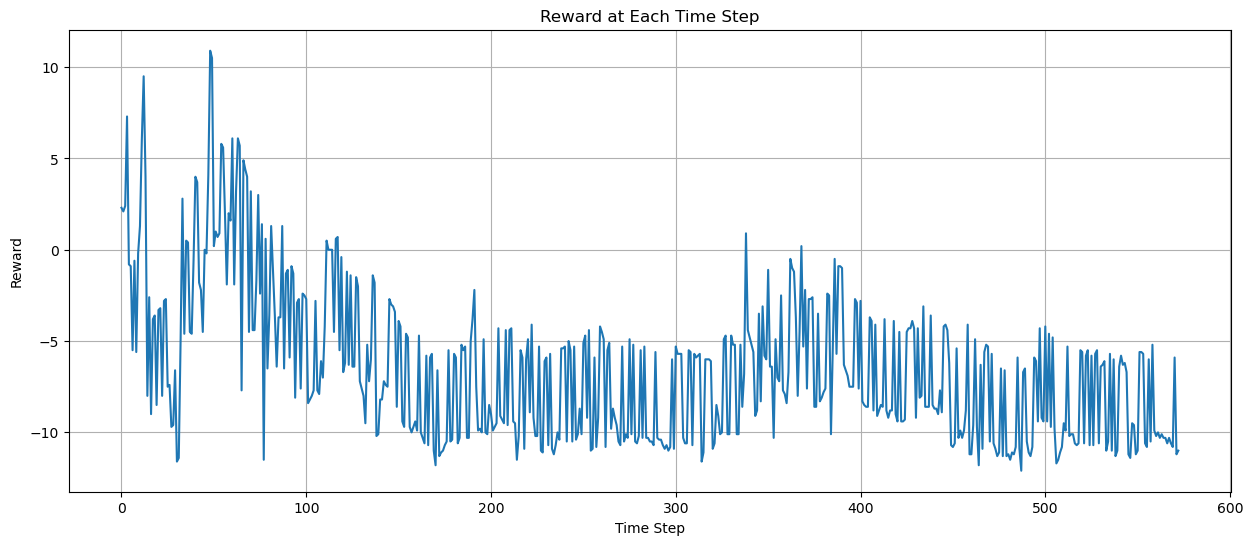

In [3]:
# Plot the rewards over time
plt.figure(figsize=(15, 6))
plt.plot(time_steps, rewards)
plt.title('Reward at Each Time Step')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

In [4]:
# Number of episodes
num_episodes = 1000

# Track results
total_rewards = []  # To store the total reward of each episode
episode_lengths = []  # To store how many time steps each episode took

# Loop over 1000 episodes
for episode in range(num_episodes):
    # Initialize a new environment for each episode
    env = TrafficEnvironment()
    
    # Reset environment to get the initial state
    state = env.reset()
    done = False
    total_reward = 0
    time_steps = 0

    # Run the simulation for the current episode
    while not done:
        # Agent chooses an action based on the current state
        action = random.choice([-1, 0, 1])
        # Environment executes the action and returns the new state, reward, and done flag
        state, reward, done = env.step(action)

        # Accumulate the total reward
        total_reward += reward

        # Increment the time step counter
        time_steps += 1

    # Store the results for this episode
    total_rewards.append(total_reward)
    episode_lengths.append(time_steps)

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

# After all episodes are done, print out the average reward and episode length
print(f"Average Total Reward over {num_episodes} episodes: {np.mean(total_rewards)}")
print(f"Average Episode Length over {num_episodes} episodes: {np.mean(episode_lengths)}")


Initial Distance:  3283.3
Initial Clearance Rates:  [15.5 18.9 19.9 16.  16.1]
Initial Lane:  2
Initial Distance:  3656.6
Initial Clearance Rates:  [17.2 18.1 17.7 16.4 17.4]
Initial Lane:  5
Initial Distance:  3835.5
Initial Clearance Rates:  [16.6 19.7 15.9 16.1 18.4]
Initial Lane:  4
Initial Distance:  3389.1
Initial Clearance Rates:  [16.8 17.8 19.8 19.8 17. ]
Initial Lane:  1
Initial Distance:  3852.6
Initial Clearance Rates:  [19.7 15.9 16.3 19.9 20. ]
Initial Lane:  5
Initial Distance:  3798.7
Initial Clearance Rates:  [17.4 16.2 18.1 17.6 15.2]
Initial Lane:  1
Initial Distance:  3144.0
Initial Clearance Rates:  [17.5 15.8 17.  19.7 19.9]
Initial Lane:  2
Initial Distance:  3281.0
Initial Clearance Rates:  [19.  18.1 19.7 16.4 17.8]
Initial Lane:  4
Initial Distance:  3643.1
Initial Clearance Rates:  [15.1 19.5 17.6 19.9 16.1]
Initial Lane:  4
Initial Distance:  3677.2
Initial Clearance Rates:  [17.5 17.4 15.9 19.5 16.7]
Initial Lane:  2
Initial Distance:  3680.7
Initial Cleara

## Rule-Based Agent

Initial Distance:  3190.3
Initial Clearance Rates:  [18.6 18.  17.5 15.1 16. ]
Initial Lane:  3
Time Step: 0, Action: -1, Reward: 2.7, Done: False
Next State: [(3190.3, 3, 18.6, 18.0, 17.5, 15.1, 16.0), (3190.3, 3, 18.6, 18.0, 17.5, 15.1, 16.0), (3172.6, 3, 18.6, 18.0, 17.7, 15.5, 16.0)]
Time Step: 1, Action: -1, Reward: 2.9, Done: False
Next State: [(3190.3, 3, 18.6, 18.0, 17.5, 15.1, 16.0), (3172.6, 3, 18.6, 18.0, 17.7, 15.5, 16.0), (3154.7, 2, 18.3, 17.9, 17.8, 16.0, 15.6)]
Time Step: 2, Action: -1, Reward: 2.9, Done: False
Next State: [(3172.6, 3, 18.6, 18.0, 17.7, 15.5, 16.0), (3154.7, 2, 18.3, 17.9, 17.8, 16.0, 15.6), (3136.8, 1, 17.9, 17.9, 18.0, 16.0, 15.8)]
Time Step: 3, Action: 1, Reward: 3.0, Done: False
Next State: [(3154.7, 2, 18.3, 17.9, 17.8, 16.0, 15.6), (3136.8, 1, 17.9, 17.9, 18.0, 16.0, 15.8), (3118.8, 1, 18.0, 18.0, 17.7, 15.9, 15.9)]
Time Step: 4, Action: 1, Reward: 2.9, Done: False
Next State: [(3136.8, 1, 17.9, 17.9, 18.0, 16.0, 15.8), (3118.8, 1, 18.0, 18.0, 17.

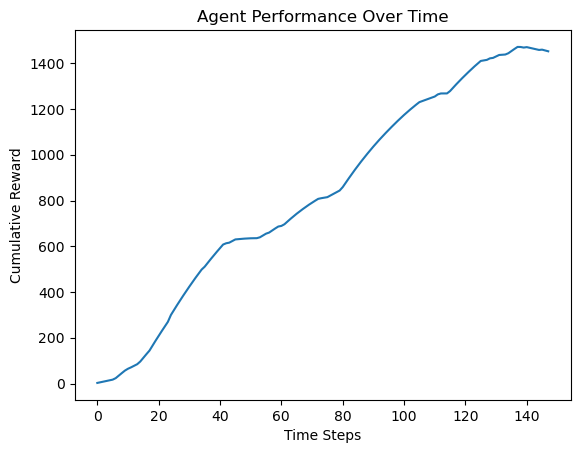

In [15]:
import numpy as np

class RuleBasedAgent:
    def __init__(self):
        # The base threshold for determining if the current lane is too slow relative to the average
        self.base_slow_threshold = 0.99
        # The base threshold for determining if an adjacent lane is significantly faster
        self.base_fast_threshold = 1.01
        # Penalty applied when the agent attempts to switch lanes (whether successful or not)
        self.lane_switch_penalty = -5

    def choose_action(self, state):
        """
        Chooses an action (-1: move left, 0: stay, 1: move right) based on the current state of the environment.

        Args:
        - state: A list of tuples representing the last three time steps. Each tuple contains
                 the distance to the destination, the current lane, and clearance rates of 5 lanes.

        Returns:
        - action (int): -1 for left, 0 for stay, and 1 for right.
        """

        # Extract the most recent state (the last time step in the list)
        current_state = state[-1]
        # Get the distance to the destination
        distance = current_state[0]
        # Get the current lane number
        current_lane = current_state[1]
        # Get the clearance rates for all lanes
        clearance_rates = current_state[2:]

        # Total number of lanes in the environment
        total_lanes = len(clearance_rates)
        # Calculate the average clearance rate across all lanes
        avg_clearance = np.mean(clearance_rates)

        # Dynamically calculate thresholds based on the remaining distance
        slow_threshold = self.calculate_slow_threshold(distance)
        fast_threshold = self.calculate_fast_threshold(distance)

        # Decision-making process: Check if the current lane is too slow
        if clearance_rates[current_lane - 1] < avg_clearance * slow_threshold:
            # If the current lane is slower than the average by a certain factor (slow_threshold),
            # consider switching to a faster adjacent lane.
            
            # If there's a lane to the left and it's faster than the current lane, move left (-1)
            if current_lane > 1 and clearance_rates[current_lane - 2] > clearance_rates[current_lane - 1]:
                return -1  # Move to the left lane
            
            # If there's a lane to the right and it's faster than the current lane, move right (1)
            elif current_lane < total_lanes and clearance_rates[current_lane] > clearance_rates[current_lane - 1]:
                return 1  # Move to the right lane
        
        # If the current lane is not too slow, check if any adjacent lane is significantly faster
        if current_lane > 1 and clearance_rates[current_lane - 2] > clearance_rates[current_lane - 1] * fast_threshold:
            # Move left if the left lane is faster by a large factor (fast_threshold)
            return -1
        elif current_lane < total_lanes and clearance_rates[current_lane] > clearance_rates[current_lane - 1] * fast_threshold:
            # Move right if the right lane is faster by a large factor (fast_threshold)
            return 1

        # If no better lanes are found, stay in the current lane
        return 0

    def calculate_slow_threshold(self, distance):
        """
        Calculate a threshold to determine if the current lane is too slow.
        The threshold increases as the distance decreases (encouraging faster lanes as the agent nears the destination).
        
        Args:
        - distance: Current distance to the destination.

        Returns:
        - slow_threshold: The calculated slow threshold.
        """
        # Increase the slow threshold as the distance decreases, making the agent more likely to avoid slow lanes
        return self.base_slow_threshold + (0.2 * distance / 5000)  # Assuming max distance is 5000 meters

    def calculate_fast_threshold(self, distance):
        """
        Calculate a threshold to determine if an adjacent lane is significantly faster.
        The threshold decreases as the distance decreases, making the agent more willing to switch to faster lanes.
        
        Args:
        - distance: Current distance to the destination.

        Returns:
        - fast_threshold: The calculated fast threshold.
        """
        # Decrease the fast threshold as the distance decreases, making the agent more aggressive in switching to faster lanes
        return self.base_fast_threshold - (0.2 * distance / 5000)  # Assuming max distance is 5000 meters


# Example of running the agent in the environment

# Initialize environment
env = TrafficEnvironment()
initial_state = env.reset()

# Initialize the agent
agent = RuleBasedAgent()

done = False
total_reward = 0
time_step_counter = 0

# Log rewards and time steps for plotting later
rewards = []
time_steps = []

# Run the simulation
while not done:
    # Agent chooses action based on the current state
    action = agent.choose_action(env.get_state())
    
    # Step the environment forward with the chosen action
    next_state, reward, done = env.step(action)
    
    # Accumulate reward and track time steps
    total_reward += reward
    rewards.append(total_reward)
    time_steps.append(time_step_counter)
    
    # Print the current time step information
    print(f"Time Step: {time_step_counter}, Action: {action}, Reward: {reward}, Done: {done}")
    print(f"Next State: {next_state}")
    
    # Increment the time step counter
    time_step_counter += 1

# After the episode ends, display total rewards and steps
print(f"Episode finished after {time_step_counter} time steps.")
print(f"Total Reward: {total_reward}")

# Optionally, you can plot the rewards over time (using matplotlib or another library)
import matplotlib.pyplot as plt

plt.plot(time_steps, rewards)
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Reward')
plt.title('Agent Performance Over Time')
plt.show()


In [16]:
# Number of episodes
num_episodes = 1000

# Initialize agent
agent = RuleBasedAgent()

# Track results
total_rewards = []  # To store the total reward of each episode
episode_lengths = []  # To store how many time steps each episode took

# Loop over 1000 episodes
for episode in range(num_episodes):
    # Initialize a new environment for each episode
    env = TrafficEnvironment()
    
    # Reset environment to get the initial state
    state = env.reset()
    done = False
    total_reward = 0
    time_steps = 0

    # Run the simulation for the current episode
    while not done:
        # Agent chooses an action based on the current state
        action = agent.choose_action(state)

        # Environment executes the action and returns the new state, reward, and done flag
        state, reward, done = env.step(action)

        # Accumulate the total reward
        total_reward += reward

        # Increment the time step counter
        time_steps += 1

    # Store the results for this episode
    total_rewards.append(total_reward)
    episode_lengths.append(time_steps)

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes} completed.")

# After all episodes are done, print out the average reward and episode length
print(f"Average Total Reward over {num_episodes} episodes: {np.mean(total_rewards)}")
print(f"Average Episode Length over {num_episodes} episodes: {np.mean(episode_lengths)}")


Initial Distance:  3857.7
Initial Clearance Rates:  [19.3 18.8 19.8 18.7 18.4]
Initial Lane:  5
Initial Distance:  3589.7
Initial Clearance Rates:  [19.5 16.3 15.7 17.8 19.4]
Initial Lane:  1
Initial Distance:  3642.8
Initial Clearance Rates:  [15.1 18.  18.6 19.4 15.8]
Initial Lane:  2
Initial Distance:  3540.0
Initial Clearance Rates:  [16.  19.2 16.2 17.  19.4]
Initial Lane:  1
Initial Distance:  3179.3
Initial Clearance Rates:  [17.4 19.7 19.  18.3 15.2]
Initial Lane:  5
Initial Distance:  3433.3
Initial Clearance Rates:  [19.9 18.9 18.4 17.  15.6]
Initial Lane:  2
Initial Distance:  3454.8
Initial Clearance Rates:  [17.6 16.3 20.  17.4 17. ]
Initial Lane:  5
Initial Distance:  3509.2
Initial Clearance Rates:  [18.2 18.  17.2 16.9 15.4]
Initial Lane:  1
Initial Distance:  3412.2
Initial Clearance Rates:  [17.7 19.6 17.8 18.3 17.5]
Initial Lane:  1
Initial Distance:  3100.3
Initial Clearance Rates:  [16.2 19.7 16.3 19.1 16.5]
Initial Lane:  4
Initial Distance:  3831.5
Initial Cleara

# Random Choice
Episode 1000/1000 completed.
Average Total Reward over 1000 episodes: -6532.615100000002
Average Episode Length over 1000 episodes: 752.943

# 0.8
# 1.2
Episode 1000/1000 completed.
Average Total Reward over 1000 episodes: -2328.0576000000005
Average Episode Length over 1000 episodes: 497.69


# 0.9
# 1.1
Episode 1000/1000 completed.
Average Total Reward over 1000 episodes: -2474.050300000001
Average Episode Length over 1000 episodes: 488.347

# 0.95
# 1.05
Episode 1000/1000 completed.
Average Total Reward over 1000 episodes: -2369.3626000000004
Average Episode Length over 1000 episodes: 468.092

# 0.99
# 1.01
Episode 1000/1000 completed.
Average Total Reward over 1000 episodes: -2985.843600000001
Average Episode Length over 1000 episodes: 501.437
